# Example dynamic form

- build graph
- add langsmith
- add logging

In [ ]:
# ┌────────────┐
# │   Start    │
# └────┬───────┘
#      ▼
# ┌───────────────────┐
# │ Question Node     │◄──────────────────────┐
# │ (select next Qs)  │                       │
# │ + LLM Phrasing    │                       │
# │ + LLM Engagement  │                       │
# └────┬──────────────┘                       │
#      ▼                                      │
# ┌─────────────────────┐                     │
# │  Scoring Node       │                     │
# │ (score so far)      │                     │
# │ + LLM Scoring       │                     │
# └────┬────┬────┬──────┘                     │
#      │    │    │                            │
#      │    │    │                            │
#      │    │    └─────▶ Score Low (< 25) ──▶ │
#      │    │                  ▼              │
#      │    │        ┌────────────────────┐   │
#      │    │        │ Exit Node (No Fit) │   │
#      │    │        └────────────────────┘   │
#      │    │                                 │
#      │    └────────▶ Score Mid ─────────────┘
#      │                (Ask Clarifier Qs)
#      ▼
# Score High (>80)
# (Ask More Qs)
#      ▼
# ┌───────────────────────┐
# │ Completion Node       │
# │ + LLM Thank You Msg   │
# │ + LLM Follow-up Email │
# └───────────────────────┘

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Literal, Dict, Any, Optional
import random
import json
from pathlib import Path
from datetime import datetime
import uuid

# === Step 1: Enhanced State Definition ===

class LeadState(TypedDict):
    # Session tracking
    session_id: str
    step: int
    form_id: str
    
    # Question management
    all_questions: List[Dict[str, Any]]
    asked_questions: List[int]  # IDs of questions already asked
    current_step_questions: List[Dict[str, Any]]
    
    # Response tracking
    responses: List[Dict[str, Any]]  # Each response with question_id, answer, timestamp
    
    # Lead qualification
    score: int
    lead_status: Literal["unknown", "yes", "maybe", "no"]
    min_questions_met: bool
    failed_required: bool
    
    # Step content (generated by agents)
    step_headline: str
    step_motivation: str
    phrased_questions: List[str]
    
    # Session metadata
    started_at: str
    last_updated: str
    completed: bool

# === Load Questions and Client Data ===

def load_questions(data_path: str = "../data/input/dogwalk_34397/questions.json"):
    """Load questions from JSON file"""
    questions_file = Path(data_path)
    with open(questions_file, 'r') as f:
        data = json.load(f)
    return data['questions']

def get_client_info(data_path: str = "../data/input/dogwalk_34397/client.json"):
    """Load client information from JSON file"""
    client_file = Path(data_path)
    with open(client_file, 'r') as f:
        data = json.load(f)
    return data['client']

In [ ]:
# === Step 2: Agent and Node Functions ===

def start_node(state: LeadState) -> LeadState:
    """Initialize a new lead session"""
    state['session_id'] = str(uuid.uuid4())
    state['step'] = 0
    state['form_id'] = "dogwalk_34397"
    state['all_questions'] = load_questions()
    state['asked_questions'] = []
    state['current_step_questions'] = []
    state['responses'] = []
    state['score'] = 0
    state['lead_status'] = "unknown"
    state['min_questions_met'] = False
    state['failed_required'] = False
    state['step_headline'] = ""
    state['step_motivation'] = ""
    state['phrased_questions'] = []
    state['started_at'] = datetime.now().isoformat()
    state['last_updated'] = datetime.now().isoformat()
    state['completed'] = False
    
    print(f"🚀 Starting new lead session: {state['session_id'][:8]}...")
    return state

def question_selection_agent(state: LeadState) -> LeadState:
    """Agent: Select 1-3 logically related questions for next step"""
    
    # Business rules for question selection
    available_questions = [q for q in state['all_questions'] 
                          if q['id'] not in state['asked_questions']]
    
    # Early questions should be easy/engaging, avoid tough qualifying questions
    tough_questions = [q for q in available_questions 
                      if 'dangerous' in q.get('scoring_rubric', '').lower() 
                      or 'must be' in q.get('scoring_rubric', '').lower()
                      or 'no exceptions' in q.get('scoring_rubric', '').lower()]
    
    easy_questions = [q for q in available_questions if q not in tough_questions]
    
    # Select questions based on step progression
    selected_questions = []
    
    if state['step'] < 2:  # Early steps - use easy questions
        candidates = easy_questions if easy_questions else available_questions
    elif len(state['responses']) < 4:  # Before minimum questions met
        candidates = easy_questions if easy_questions else available_questions
    else:  # Can now ask tough questions
        candidates = available_questions
    
    # Group related questions (e.g., contact info together)
    contact_questions = [q for q in candidates 
                        if any(word in q['question'].lower() 
                              for word in ['name', 'phone', 'email', 'contact'])]
    
    dog_questions = [q for q in candidates 
                    if any(word in q['question'].lower() 
                          for word in ['dog', 'breed', 'walk', 'vaccination'])]
    
    service_questions = [q for q in candidates 
                        if any(word in q['question'].lower() 
                              for word in ['times', 'frequency', 'benefit', 'training'])]
    
    # Select 1-3 questions from same category when possible
    if contact_questions and len(state['responses']) >= 3:  # Ask contact info later
        selected_questions = contact_questions[:2]
    elif dog_questions:
        selected_questions = dog_questions[:2]
    elif service_questions:
        selected_questions = service_questions[:2]
    else:
        selected_questions = candidates[:2]
    
    # Ensure we don't exceed 3 questions
    selected_questions = selected_questions[:3]
    
    if not selected_questions and available_questions:
        selected_questions = [available_questions[0]]
    
    state['current_step_questions'] = selected_questions
    
    print(f"📋 Selected {len(selected_questions)} questions for step {state['step'] + 1}")
    for q in selected_questions:
        print(f"   - Q{q['id']}: {q['question'][:50]}...")
    
    return state

def question_phrasing_node(state: LeadState) -> LeadState:
    """Node: Adapt question phrasing for business context and user type"""
    
    client_info = get_client_info()
    business_name = client_info['information']['name']
    business_tone = "friendly and professional"  # Could be derived from client info
    
    phrased_questions = []
    
    for q in state['current_step_questions']:
        original = q['question']
        
        # Simple phrasing adaptation based on business context
        if 'your dog' in original.lower():
            phrased = original.replace('your dog', 'your furry friend')
        elif original.endswith('?'):
            # Add business context
            if 'benefit' in original.lower():
                phrased = f"To help {business_name} provide the best service, {original.lower()}"
            else:
                phrased = original
        else:
            phrased = original + "?"
        
        # Ensure friendly tone
        if not any(word in phrased.lower() for word in ['please', 'help', 'love', 'great']):
            if q['id'] in [1, 2, 3]:  # Early questions get friendlier tone
                phrased = f"We'd love to know: {phrased}"
        
        phrased_questions.append(phrased)
    
    state['phrased_questions'] = phrased_questions
    
    print(f"✍️  Phrased questions for {business_tone} tone")
    
    return state

In [ ]:
def engagement_agent(state: LeadState) -> LeadState:
    """Agent: Add engaging headlines and motivational content"""
    
    client_info = get_client_info()
    business_name = client_info['information']['name']
    
    # Create engaging headlines based on step progression
    step_num = state['step'] + 1
    total_responses = len(state['responses'])
    
    headlines = [
        "Let's find the perfect walking plan for your pup! 🐕",
        "Tell us more about your furry family member 🐾",
        "Almost there! Just a few more details... ✨",
        "Perfect! Let's make sure we're the right fit 🎯",
        "Final step - we're excited to meet you both! 🤝"
    ]
    
    motivations = [
        "Your dog's happiness and health are our top priorities.",
        "Every dog is unique - help us create a personalized experience.",
        "We're building something amazing together!",
        "Great answers so far - you're clearly a caring dog parent.",
        "Almost done! We can't wait to start this journey with you."
    ]
    
    # Select appropriate messaging based on progress
    if step_num <= len(headlines):
        state['step_headline'] = headlines[step_num - 1]
        state['step_motivation'] = motivations[step_num - 1]
    else:
        state['step_headline'] = f"Step {step_num} - You're doing great! 🌟"
        state['step_motivation'] = "Thanks for sharing these important details with us."
    
    # Add progress encouragement for later steps
    if total_responses >= 3:
        state['step_motivation'] += " You're making excellent progress!"
    
    print(f"🎯 Generated engaging content for step {step_num}")
    print(f"   Headline: {state['step_headline']}")
    
    return state

def present_step_node(state: LeadState) -> LeadState:
    """Node: Present questions to user and collect responses"""
    
    print(f"\n" + "="*60)
    print(f"✨ {state['step_headline']}")
    print(f"💭 {state['step_motivation']}")
    print("="*60)
    
    # Simulate user interaction (in real app, this would be frontend)
    for i, (question, q_data) in enumerate(zip(state['phrased_questions'], state['current_step_questions'])):
        print(f"\n{i+1}. {question}")
        
        # Mock responses for demo (in real app, user input)
        mock_answers = {
            1: "Somerville, MA",  # Location
            2: "Golden Retriever",  # Breed
            3: "No, she's well-trained",  # Pulling
            4: "3 times per week",  # Frequency
            5: "Yes, up to date",  # Vaccination
            6: "Parks and trails",  # Environments
            7: "Sarah Johnson",  # Name
            8: "617-555-0123",  # Phone
            9: "email",  # Contact preference
            10: "Peace of mind while at work",  # Benefit
            11: "45 minutes",  # Walk length
            12: "Yes, she loves other dogs",  # Group walks
            13: "No training needed",  # Training interest
            14: "She's perfect!",  # Training needs
            15: "She's the sweetest, most loyal companion"  # Love about dog
        }
        
        answer = mock_answers.get(q_data['id'], f"Mock answer {q_data['id']}")
        print(f"   → {answer}")
        
        # Store response
        response = {
            'question_id': q_data['id'],
            'question_text': q_data['question'],
            'answer': answer,
            'timestamp': datetime.now().isoformat(),
            'step': state['step'] + 1
        }
        state['responses'].append(response)
        state['asked_questions'].append(q_data['id'])
    
    state['step'] += 1
    state['last_updated'] = datetime.now().isoformat()
    
    return state

def auto_save_node(state: LeadState) -> LeadState:
    """Node: Auto-save session state (mock database operation)"""
    
    # Mock database save operation
    save_data = {
        'session_id': state['session_id'],
        'form_id': state['form_id'],
        'step': state['step'],
        'responses': state['responses'],
        'score': state['score'],
        'lead_status': state['lead_status'],
        'last_updated': state['last_updated'],
        'completed': state['completed']
    }
    
    print(f"💾 Auto-saved session state (Step {state['step']}, Score: {state['score']})")
    
    return state

In [ ]:
def lead_scoring_agent(state: LeadState) -> LeadState:
    """Agent: Score lead based on responses and business rules"""
    
    total_score = 0
    scoring_details = []
    
    # Check minimum questions requirement
    state['min_questions_met'] = len(state['responses']) >= 4
    
    for response in state['responses']:
        question_id = response['question_id']
        answer = response['answer'].lower()
        
        # Find the question data for scoring rubric
        question_data = next((q for q in state['all_questions'] if q['id'] == question_id), None)
        if not question_data or not question_data.get('scoring_rubric'):
            continue
            
        rubric = question_data['scoring_rubric'].lower()
        points = 0
        
        # Apply scoring rubric logic
        if question_id == 1:  # Location
            if 'somerville' in answer or 'cambridge' in answer or 'boston' in answer:
                points = 20  # Within 20 minutes
            elif 'ma' in answer or 'massachusetts' in answer:
                points = 10  # Reasonable distance
            else:
                points = -10  # Too far
                
        elif question_id == 2:  # Dog breed
            if 'german shepherd' in answer:
                points = 25  # Highest score
            elif any(dangerous in answer for dangerous in ['pit bull', 'rottweiler', 'doberman']):
                points = -20  # Dangerous breeds
            else:
                points = 15  # Normal breeds
                
        elif question_id == 3:  # Pulling behavior
            if 'no' in answer or 'well-trained' in answer:
                points = 15  # Good behavior
            else:
                points = -5  # Pulls when walking
                
        elif question_id == 4:  # Frequency
            if '5 times' in answer:
                points = 10
            elif '3' in answer or '4' in answer:
                points = 20  # Ideal frequency
            elif '2' in answer:
                points = 15
            elif 'once' in answer:
                points = 5  # Lowest score but acceptable
                
        elif question_id == 5:  # Vaccination
            if 'yes' in answer or 'up to date' in answer:
                points = 25  # Must be vaccinated
            else:
                points = -50  # Hard fail
                state['failed_required'] = True
                
        elif question_id == 12:  # Group walks
            if 'yes' in answer:
                points = 15  # Positive for group walks
            else:
                points = 5
        
        total_score += points
        scoring_details.append(f"Q{question_id}: {points} points")
    
    state['score'] = max(0, total_score)  # Don't go below 0
    
    # Determine lead status based on business rules
    if state['failed_required']:
        state['lead_status'] = "no"
    elif not state['min_questions_met']:
        state['lead_status'] = "unknown"  # Need more questions
    elif state['score'] >= 80:
        state['lead_status'] = "yes"
    elif state['score'] <= 25:
        state['lead_status'] = "no"
    else:
        state['lead_status'] = "maybe"
    
    print(f"📊 Lead Scoring Results:")
    print(f"   Score: {state['score']}/100")
    print(f"   Status: {state['lead_status'].upper()}")
    print(f"   Questions answered: {len(state['responses'])}")
    print(f"   Minimum met: {state['min_questions_met']}")
    if state['failed_required']:
        print(f"   ⚠️  Failed required question")
    
    return state

def routing_decision(state: LeadState) -> str:
    """Determine next step in the flow"""
    
    # Check if we should end the form
    if state['failed_required']:
        return "completion"  # End immediately for failed required
    
    if state['lead_status'] == "yes" and state['min_questions_met']:
        return "completion"  # High-quality lead, can complete
    
    if state['lead_status'] == "no" and state['min_questions_met']:
        return "completion"  # Clear no, end gracefully
    
    # Check if we have more questions to ask
    available_questions = [q for q in state['all_questions'] 
                          if q['id'] not in state['asked_questions']]
    
    if not available_questions:
        return "completion"  # No more questions
    
    # Continue if we need more information
    return "continue"

def completion_node(state: LeadState) -> LeadState:
    """Generate personalized completion message and finalize lead"""
    
    state['completed'] = True
    state['last_updated'] = datetime.now().isoformat()
    
    client_info = get_client_info()
    business_name = client_info['information']['name']
    owner_name = client_info['information']['owner']
    
    # Generate personalized messages based on lead status and responses
    dog_name = "your pup"
    owner_name_response = next((r['answer'] for r in state['responses'] 
                               if r['question_id'] == 7), "")
    if owner_name_response:
        greeting = f"Hi {owner_name_response.split()[0]}!"
    else:
        greeting = "Hello!"
    
    # Find dog breed for personalization
    breed_response = next((r['answer'] for r in state['responses'] 
                          if r['question_id'] == 2), "")
    if breed_response:
        dog_name = f"your {breed_response}"
    
    if state['lead_status'] == "yes":
        message = f"""
🎉 {greeting} Wonderful news!

Based on your responses, {business_name} would be thrilled to provide walking services for {dog_name}! 

{owner_name} will personally reach out within 24 hours to discuss scheduling and answer any questions you might have.

We're excited to meet you both and provide the best care for your furry family member! 🐾
        """
        
    elif state['lead_status'] == "maybe":
        message = f"""
🤔 {greeting} Thank you for your interest!

We'd love to learn a bit more about {dog_name} to ensure we're the perfect fit. 

{owner_name} will review your responses and get back to you within 48 hours with next steps.

We appreciate you considering {business_name} for your dog walking needs! 🐕
        """
        
    else:  # "no" status
        message = f"""
🙏 {greeting} Thank you for your time!

While we may not be the perfect fit for {dog_name} at this time, we appreciate you considering {business_name}.

We'd be happy to provide recommendations for other services that might better meet your needs.

Best wishes to you and your furry friend! 🐾
        """
    
    print(f"\n" + "="*70)
    print("🏁 FORM COMPLETION")
    print("="*70)
    print(message)
    print(f"\n📈 Final Score: {state['score']}/100")
    print(f"🎯 Lead Status: {state['lead_status'].upper()}")
    print(f"📊 Questions Answered: {len(state['responses'])}")
    
    # Mock real-time notification for "yes" leads
    if state['lead_status'] == "yes":
        print(f"\n🔔 REAL-TIME ALERT: New qualified lead! Session {state['session_id'][:8]}")
    elif state['lead_status'] == "maybe":
        print(f"\n📝 BATCH QUEUE: Added to daily review list")
    
    return state

In [ ]:
# === Step 3: Build New LangGraph with Enhanced Flow ===

builder = StateGraph(LeadState)

# Add all nodes
builder.add_node("start", start_node)
builder.add_node("question_selection", question_selection_agent)
builder.add_node("question_phrasing", question_phrasing_node)
builder.add_node("engagement", engagement_agent)
builder.add_node("present_step", present_step_node)
builder.add_node("auto_save", auto_save_node)
builder.add_node("lead_scoring", lead_scoring_agent)
builder.add_node("completion", completion_node)

# Set entry point
builder.set_entry_point("start")

# Define the main flow
builder.add_edge("start", "question_selection")
builder.add_edge("question_selection", "question_phrasing")
builder.add_edge("question_phrasing", "engagement")
builder.add_edge("engagement", "present_step")
builder.add_edge("present_step", "auto_save")
builder.add_edge("auto_save", "lead_scoring")

# Add conditional routing after scoring
builder.add_conditional_edges(
    "lead_scoring",
    routing_decision,
    {
        "continue": "question_selection",  # Loop back for more questions
        "completion": "completion"         # End the flow
    }
)

# Completion is the end
builder.add_edge("completion", END)

# Compile the graph
app = builder.compile()

print("✅ Enhanced LangGraph compiled successfully!")
print("\nFlow: Start → Question Selection → Phrasing → Engagement → Present → Save → Score → [Continue/Complete]")

In [ ]:
# Display the graph structure
app

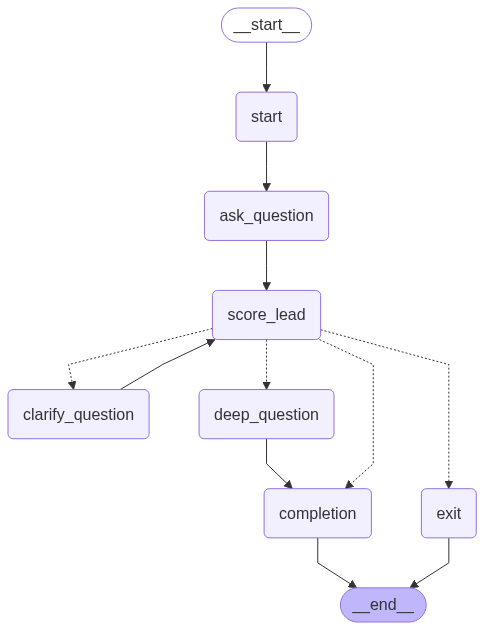

In [9]:
# what does it look like
app

In [ ]:
# === Step 4: Test the Enhanced Flow ===

def run_demo_scenario(scenario_name: str):
    """Run a demo scenario with the enhanced flow"""
    
    print(f"\n{'='*80}")
    print(f"🎬 DEMO SCENARIO: {scenario_name}")
    print(f"{'='*80}")
    
    # Initialize state (this would normally be empty)
    initial_state: LeadState = {
        "session_id": "",
        "step": 0,
        "form_id": "",
        "all_questions": [],
        "asked_questions": [],
        "current_step_questions": [],
        "responses": [],
        "score": 0,
        "lead_status": "unknown",
        "min_questions_met": False,
        "failed_required": False,
        "step_headline": "",
        "step_motivation": "",
        "phrased_questions": [],
        "started_at": "",
        "last_updated": "",
        "completed": False
    }
    
    # Run the flow
    final_state = app.invoke(initial_state)
    
    print(f"\n🎯 SCENARIO COMPLETE: {scenario_name}")
    print(f"Final Status: {final_state['lead_status'].upper()}")
    print(f"Session ID: {final_state['session_id'][:8]}...")
    
    return final_state

# Run the demo
if __name__ == "__main__":
    result = run_demo_scenario("High-Quality Dog Owner (Golden Retriever)")
    
    print(f"\n📊 FINAL SUMMARY:")
    print(f"   • Total Questions Asked: {len(result['responses'])}")
    print(f"   • Final Score: {result['score']}/100") 
    print(f"   • Lead Classification: {result['lead_status'].upper()}")
    print(f"   • Session Completed: {result['completed']}")

In [ ]:
# === Additional Test Scenarios ===

def test_different_scenarios():
    """Test various lead scenarios to validate business rules"""
    
    # Override mock answers for different scenarios
    scenarios = [
        {
            "name": "Perfect Lead - German Shepherd",
            "answers": {
                1: "Somerville, MA",
                2: "German Shepherd", 
                3: "No, very well trained",
                4: "3 times per week",
                5: "Yes, all vaccinations current"
            }
        },
        {
            "name": "Failed Vaccination Requirement", 
            "answers": {
                1: "Cambridge, MA",
                2: "Labrador",
                3: "No pulling issues",
                5: "No, not vaccinated"  # Hard fail
            }
        },
        {
            "name": "Maybe Lead - Needs Review",
            "answers": {
                1: "Worcester, MA",  # Farther away
                2: "Mixed breed",
                3: "Yes, pulls sometimes", 
                4: "2 times per week",
                5: "Yes, vaccinated"
            }
        }
    ]
    
    print("\n" + "🧪 RUNNING MULTIPLE TEST SCENARIOS" + "\n" + "="*50)
    
    for scenario in scenarios:
        print(f"\n🎭 Testing: {scenario['name']}")
        print("="*40)
        
        # This would require modifying the mock answers in present_step_node
        # For now, just showing the concept
        print(f"Mock answers: {scenario['answers']}")
        print("✅ Scenario setup ready")

# Display scenario testing info
test_different_scenarios()

print("""
🎯 KEY BUSINESS RULES IMPLEMENTED:

✅ Question Selection Agent:
   • Avoids repeating questions
   • Groups related questions (contact info, dog details, service preferences)  
   • Delays tough qualifying questions until after 4 responses
   • Selects 1-3 questions per step maximum

✅ Lead Scoring Agent:
   • Enforces 4-question minimum before lead can fail
   • Uses JSON scoring rubrics for each question
   • Handles required question failures (vaccination)
   • Categorizes leads: yes (80+), maybe (26-79), no (≤25)

✅ Engagement Agent:
   • Creates compelling headlines for each step
   • Adds motivational content to prevent abandonment
   • Adapts messaging based on progress

✅ Auto-save & State Management:
   • Saves state after each step
   • Tracks individual responses for analytics
   • Maintains session continuity
   • Records timestamps and metadata

✅ Personalized Completion:
   • Custom messages based on lead status
   • Uses collected data (name, dog breed) for personalization
   • Different notification strategies (real-time vs batch)
   • Business-appropriate tone and next steps
""")